In [15]:
# %pip install pandas
# %pip install langchain langchain_community
# %pip install neo4j
# %pip install langchain_openai
# %pip install python-dotenv
# %pip install chromadb
# %pip install "numpy<2"
# %pip install networkx
# %pip install matplotlib
# %pip install dowhy

## Root cause analysis using Response Times

In [26]:

import pandas as pd
import os
from langchain_community.graphs import Neo4jGraph
from langchain_core.messages import AIMessage
from langchain_openai import AzureChatOpenAI, AzureOpenAIEmbeddings
from dotenv import load_dotenv
from rca_buider import get_data, get_data_from_graph
import networkx as nx

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
os.environ['NEO4J_URI'] = 'bolt://localhost:7690'
os.environ['NEO4J_USERNAME'] = 'neo4j'
os.environ['NEO4J_PASSWORD'] = 'Password@123'
graph = Neo4jGraph()
load_dotenv()

True

In [18]:
# the below pivot ignores asynchronous calls
df_operationIds_anomaly, df_operationIds_normal = get_data_from_graph(graph)
normal_data, nx_graph = get_data(df_operationIds_normal, filter="r.total_duration <= 2000")
anomaly_data, _= get_data(df_operationIds_anomaly, filter="r.total_duration > 2000")

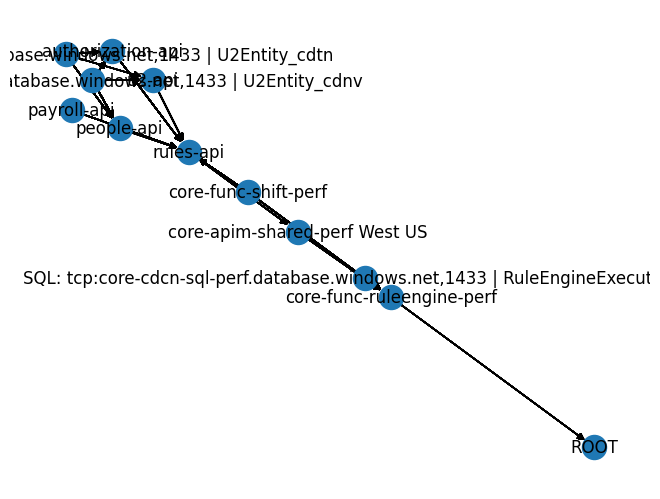

In [27]:
nx.draw(nx_graph, with_labels = True)

A better representation from Neo4j <br/>
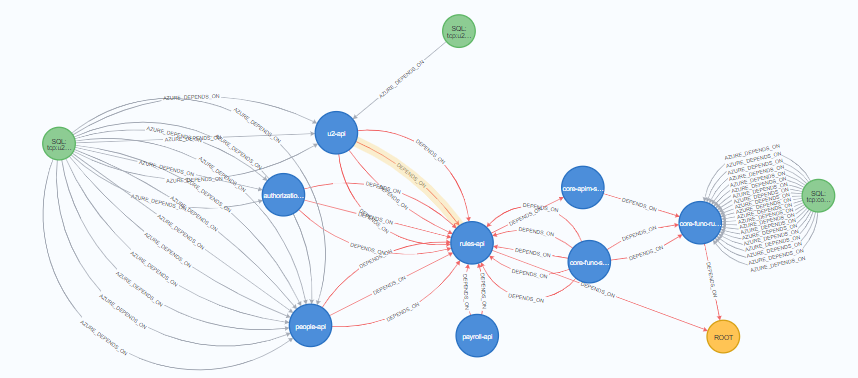

In [19]:
anomaly_data.head()

,"SQL: tcp:core-cdcn-sql-perf.database.windows.net,1433 | RuleEngineExecutionLog","SQL: tcp:u2-sql-perf.database.windows.net,1433 | U2Entity_cdnv","SQL: tcp:u2-sql-perf.database.windows.net,1433 | U2Entity_cdtn","SQL: tcp:u2-sql-perf.database.windows.net,1433 | U2Role",authorization-api,core-apim-shared-perf West US,core-func-ruleengine-perf,core-func-shift-perf,payroll-api,people-api,rules-api,u2-api,ROOT
0,0.056348,0.000000,0.295009,0.001661,8.697961,9.136191,10.028200,0.110399,0.008627,14.830264,9.203931,0.480365,9.050872
1,0.537064,0.000000,0.826923,1.004121,4.631340,9.461322,10.396208,0.123611,0.008272,11.954929,8.856363,1.319858,8.856363
2,0.077367,0.284285,0.000000,0.001798,5.333006,4.391611,5.528838,0.172187,0.349634,2.914713,4.398937,0.593024,4.301687
3,0.097318,0.000000,0.205472,0.000000,0.165817,9.215524,10.020855,0.116420,0.007891,4.184968,8.805360,0.098285,8.805360
4,0.059224,0.000000,1.797101,0.004459,12.100575,8.678279,9.504331,0.133843,3.418001,4.475265,8.739885,1.547453,8.540543


In [20]:
normal_data.head()

,"SQL: tcp:core-cdcn-sql-perf.database.windows.net,1433 | RuleEngineExecutionLog","SQL: tcp:u2-sql-perf.database.windows.net,1433 | U2Entity_cdnv","SQL: tcp:u2-sql-perf.database.windows.net,1433 | U2Entity_cdtn",authorization-api,core-apim-shared-perf West US,core-func-ruleengine-perf,core-func-shift-perf,payroll-api,people-api,rules-api,u2-api,ROOT
0,0.048265,0.099828,0.000000,0.013624,1.000172,1.231674,0.225474,0.012738,0.111787,0.989127,0.007748,0.989127
1,0.053788,0.000000,0.358084,0.017209,0.899664,1.087767,0.120148,0.136756,0.665854,0.887607,0.614877,0.887607
2,0.047459,0.103440,0.000000,0.015804,0.361863,0.514359,0.182479,0.140565,0.119474,0.348885,0.012322,0.348885
3,0.049988,0.073444,0.000000,0.014465,0.514686,0.676807,0.201278,0.007679,0.096055,0.483006,0.010849,0.483006
4,0.042967,0.000000,0.225462,0.049927,0.307142,0.430033,0.112420,0.089229,0.171286,0.283295,0.052013,0.283295


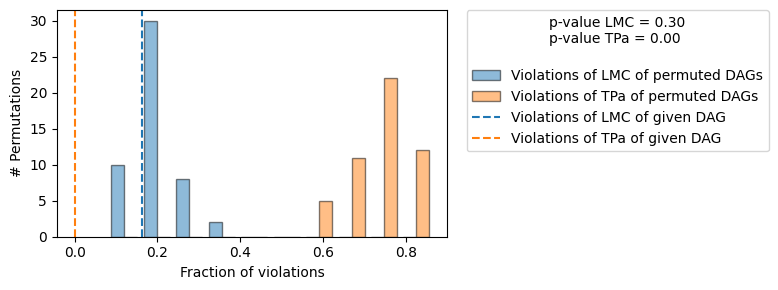

Evaluated the performance of the causal mechanisms and the invertibility assumption of the causal mechanisms and the overall average KL divergence between generated and observed distribution and the graph structure. The results are as follows:

==== Evaluation of Causal Mechanisms ====
The used evaluation metrics are:
- KL divergence (only for root-nodes): Evaluates the divergence between the generated and the observed distribution.
- Mean Squared Error (MSE): Evaluates the average squared differences between the observed values and the conditional expectation of the causal mechanisms.
- Normalized MSE (NMSE): The MSE normalized by the standard deviation for better comparison.
- R2 coefficient: Indicates how much variance is explained by the conditional expectations of the mechanisms. Note, however, that this can be misleading for nonlinear relationships.
- F1 score (only for categorical non-root nodes): The harmonic mean of the precision and recall indicating the goodness of the under

In [21]:
from dowhy import gcm
from scipy.stats import halfnorm
from dowhy.utils import plot, bar_plot

causal_model = gcm.StructuralCausalModel(nx_graph)
for node in nx_graph.nodes:
    if len(list(nx_graph.predecessors(node))) > 0:
        # for all nodes with parents, we are using the linear regression model. 
        # in real world we need to use the appropriate model based on the data distribution.
        causal_model.set_causal_mechanism(node, gcm.AdditiveNoiseModel(gcm.ml.create_linear_regressor()))
    else:
        # for all nodes without parents, we are using the half normal distribution.
        # in real world we need to use the appropriate model based on the data distribution.
        causal_model.set_causal_mechanism(node, gcm.ScipyDistribution(halfnorm))
        
gcm.fit(causal_model, normal_data)
result = gcm.evaluate_causal_model(causal_model, normal_data)
print(result)

In [23]:
gcm.config.disable_progress_bars() # to disable print statements when computing Shapley values

median_attribs, uncertainty_attribs = gcm.confidence_intervals(
    gcm.fit_and_compute(gcm.attribute_anomalies,
                        causal_model,
                        normal_data,
                        target_node='ROOT',
                        anomaly_samples=anomaly_data),
    num_bootstrap_resamples=1)

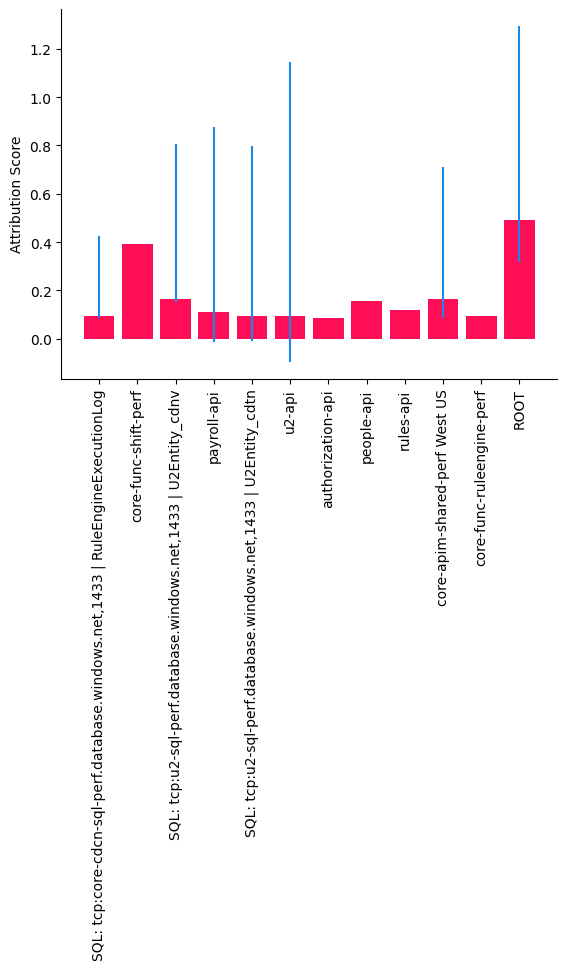

In [24]:
bar_plot(median_attribs, uncertainty_attribs, 'Attribution Score')